# 1. Install Dependencies and Setup

In [10]:
! pip install standard-imghdr

In [1]:
!pip install opencv-python matplotlib

In [2]:
!pip list

Package                  Version
------------------------ -----------
absl-py                  2.1.0
asttokens                3.0.0
astunparse               1.6.3
certifi                  2024.12.14
charset-normalizer       3.4.0
comm                     0.2.2
contourpy                1.3.1
cycler                   0.12.1
debugpy                  1.8.11
decorator                5.1.1
executing                2.1.0
flatbuffers              24.3.25
fonttools                4.55.3
gast                     0.6.0
google-pasta             0.2.0
grpcio                   1.68.1
h5py                     3.12.1
idna                     3.10
ipykernel                6.29.5
ipython                  8.30.0
jedi                     0.19.2
jupyter_client           8.6.3
jupyter_core             5.7.2
keras                    3.7.0
kiwisolver               1.4.7
libclang                 18.1.1
Markdown                 3.7
markdown-it-py           3.0.0
MarkupSafe               3.0.2
matplotlib        

In [5]:
import tensorflow as tf
import os
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 2. Remove dodgy images

In [28]:
import cv2
import imghdr

In [8]:
data_dir = 'data' 

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [26]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list data/Tumor/meningioma (143).jpg:Zone.Identifier
Image not in ext list data/Tumor/glioma (67).jpg:Zone.Identifier
Image not in ext list data/Tumor/meningioma (27).jpg:Zone.Identifier
Image not in ext list data/Tumor/meningioma (755).jpg:Zone.Identifier
Image not in ext list data/Tumor/pituitary (212).jpg:Zone.Identifier
Image not in ext list data/Tumor/glioma (545).jpg:Zone.Identifier
Image not in ext list data/Tumor/tumor (262).jpg:Zone.Identifier
Image not in ext list data/Tumor/tumor (166).jpg:Zone.Identifier
Image not in ext list data/Tumor/glioma (450).jpg:Zone.Identifier
Image not in ext list data/Tumor/tumor (462).jpg:Zone.Identifier
Image not in ext list data/Tumor/pituitary (524).jpg:Zone.Identifier
Image not in ext list data/Tumor/tumor (437).jpg:Zone.Identifier
Image not in ext list data/Tumor/tumor (529).jpg:Zone.Identifier
Image not in ext list data/Tumor/tumor (390).jpg:Zone.Identifier
Image not in ext list data/Tumor/pituitary (584).jpg:Zone.Identifi

# 3. Load Data

In [43]:
import numpy as np
from matplotlib import pyplot as plt

In [62]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 4998 files belonging to 2 classes.


In [63]:
data_iterator = data.as_numpy_iterator()

In [64]:
batch = data_iterator.next()

In [65]:
# Image represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [66]:
# Class 0 = Healthy
# Class 1 = Tumor
batch[1]

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1], dtype=int32)

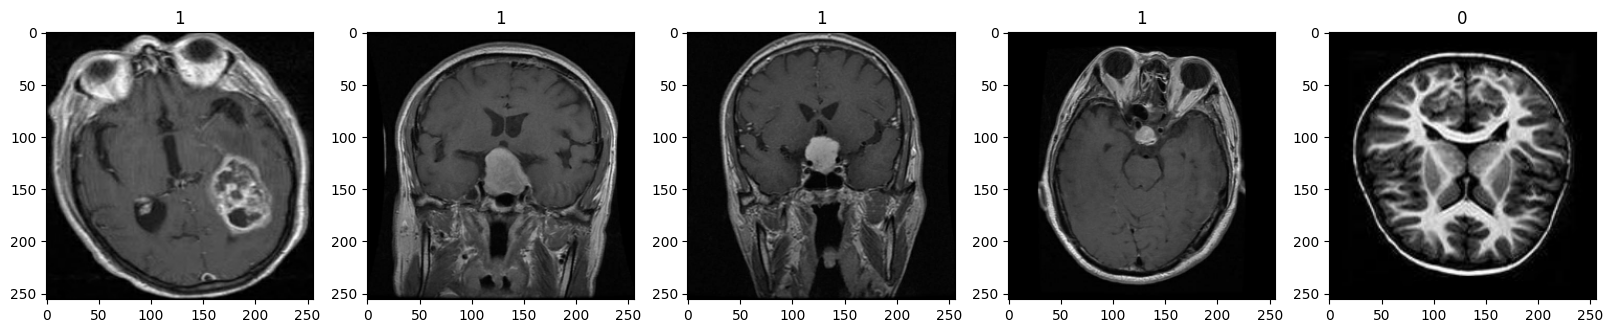

In [70]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [73]:
batch[0].min()

np.float32(0.0)

# 4. Scale Data

In [74]:
data = data.map(lambda x,y: (x/255, y))

In [75]:
scaled_iterator = data.as_numpy_iterator()

In [76]:
batch = scaled_iterator.next()

In [80]:
batch[0].max()

np.float32(1.0)

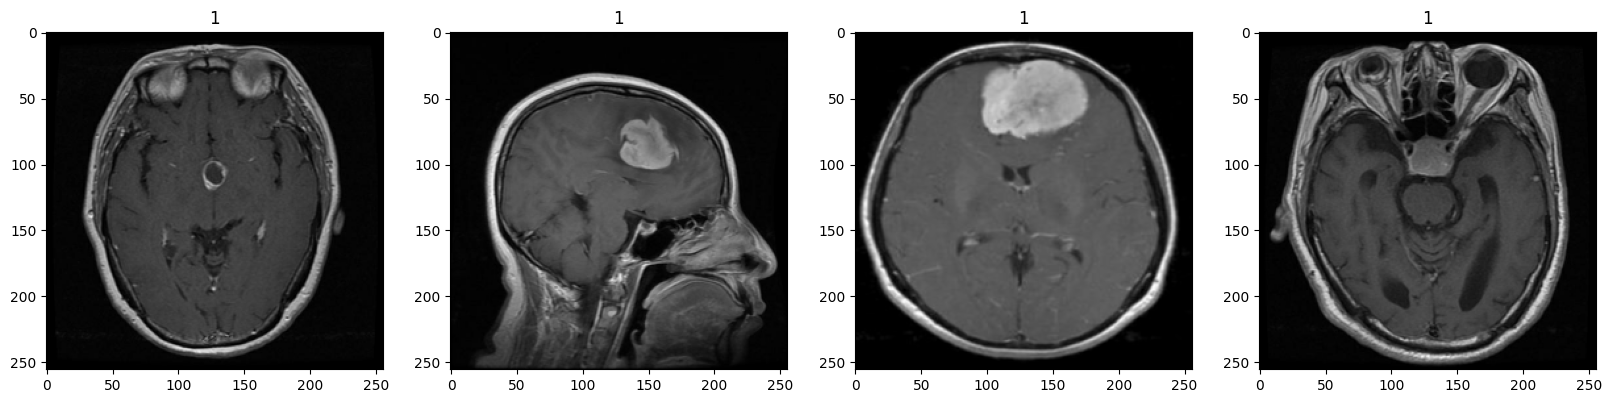

In [77]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# 5. Split Data

In [82]:
len(data)

157

In [94]:
train_size = int(len(data)*.7)+1
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [99]:
train_size+test_size+val_size

157

In [100]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [101]:
len(train)

110

# 6. Build Deep Learning Model

In [102]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [103]:
import keras
from keras import layers

In [104]:
print(keras.__version__)

3.7.0


In [106]:
model = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation="relu"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        
        layers.Dense(256, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [107]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [108]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [109]:
logdir='logs'

In [110]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [111]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


I0000 00:00:1734600436.488843   18811 service.cc:148] XLA service 0x7fdef8209090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734600436.491271   18811 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-12-19 09:27:16.810439: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734600437.124151   18811 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1734600440.218311   18811 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


110/110 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.7069 - loss: 0.5618 - val_accuracy: 0.8350 - val_loss: 0.3973
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9044 - loss: 0.2375 - val_accuracy: 0.9492 - val_loss: 0.1588
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9608 - loss: 0.1190 - val_accuracy: 0.9521 - val_loss: 0.1506
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9769 - loss: 0.0619 - val_accuracy: 0.9512 - val_loss: 0.1726
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9899 - loss: 0.0364 - val_accuracy: 0.9580 - val_loss: 0.1271
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9920 - loss: 0.0214 - val_accuracy: 0.9512 - val_loss: 0.1500
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9885 - loss: 0.0369 - val_accuracy: 0.9639 - val_loss: 0.1384
Epoch 8/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9861 - loss: 0.0393 - val_accuracy: 0.96

# 8. Plot Performance

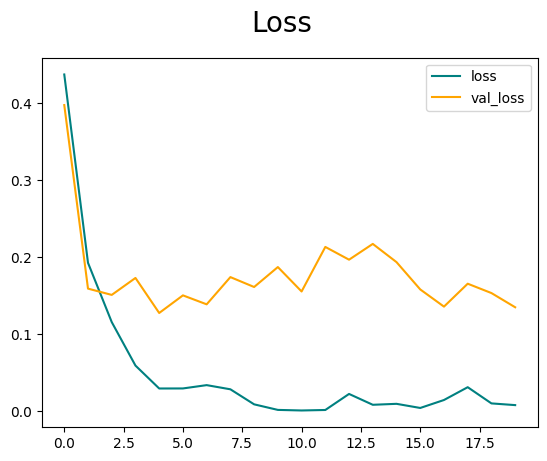

In [114]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

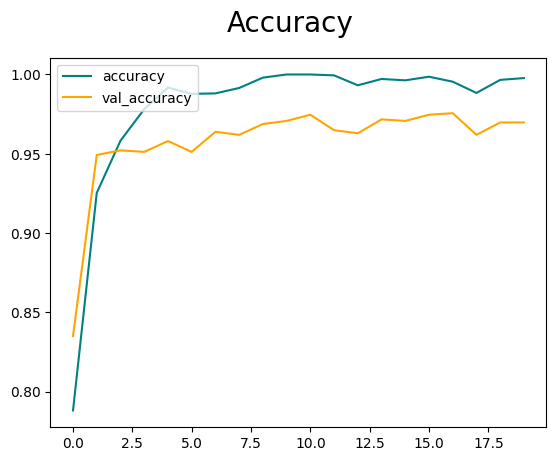

In [116]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [117]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [118]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [119]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


2024-12-19 10:28:35.663821: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [131]:
print(f"Precision: {pre.result().numpy():.3f}, \nRecall: {re.result().numpy():.3f}, \nAccuracy: {acc.result().numpy():.3f}")

Precision: 0.978, 
Recall: 0.974, 
Accuracy: 0.971


# 10. Test

In [121]:
import cv2

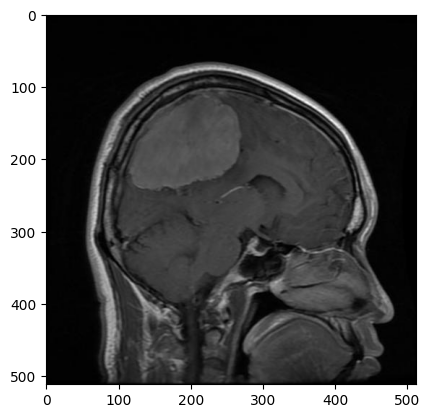

In [122]:
img = cv2.imread('tumor (571).jpg')
plt.imshow(img)
plt.show()

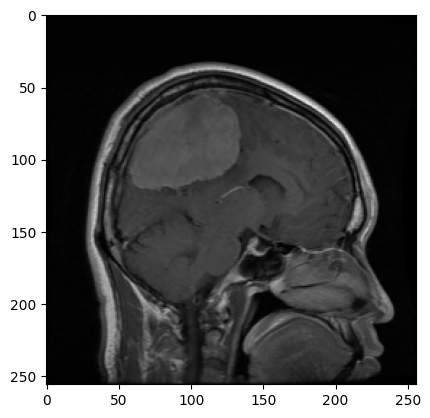

In [123]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [124]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


In [125]:
yhat

array([[0.9999999]], dtype=float32)

In [126]:
if yhat > 0.5: 
    print(f'Predicted class = Tumor')
else:
    print(f'Predicted class = Healthy')

Predicted class = Tumor


# 11. Save the Model

In [132]:
from tensorflow.keras.models import load_model

In [136]:
model.save(os.path.join('models','01_ImageClassifierBrainTumor_Model.keras'))

In [137]:
new_model = load_model(os.path.join('models','01_ImageClassifierBrainTumor_Model.keras'))

In [138]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


array([[0.9999999]], dtype=float32)